# POC 2 de Faces de Lote

Para estudar o método foi selecionada uma pequena área, mais reticulada e ortogonal para poder testar um método para indetificar e associar cada face do lote ao seu respectivo viário, extraindo a feição da testada associada.

In [211]:
import geopandas as gpd
from shapely.geometry import Point, LineString, MultiPoint, MultiLineString
from shapely.ops import nearest_points
import pandas as pd

## Abrindo as camadas de lotes e logradouros

In [136]:
gdf_lotes = gpd.read_file('download/poc-teste-faces-lote.gpkg', driver='GPKG', layer='poc2-lotes')
gdf_vias = gpd.read_file('download/poc-teste-faces-lote.gpkg', driver='GPKG', layer='poc2-logradouros')

In [137]:
gdf_vias = gdf_vias.dissolve(by='codlog').reset_index()

## Trabalhando apenas as faces externas da quadra

Para trabalhar apenas com as faces externas da quadra. Para isso vamos dissolver as geometrias dos lotes e então trabalhar apenas com os segmentos da borda exterior

<AxesSubplot:>

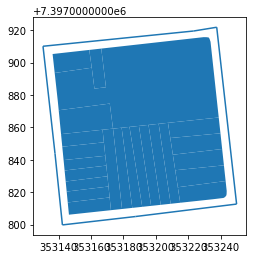

In [138]:
ax = gdf_lotes.plot()
gdf_vias.plot(ax=ax)

In [139]:
gdf_lotes.columns

Index(['cd_identificador', 'cd_setor_fiscal', 'cd_tipo_quadra',
       'cd_identificador_original_lote', 'cd_subquadra_fiscal',
       'cd_condominio', 'cd_tipo_lote', 'cd_lote', 'qt_area_terreno',
       'cd_quadra_fiscal', 'cd_situacao_geocodificacao',
       'cd_numero_situacao_geocod', 'tx_escala', 'sg_fonte_original',
       'dt_criacao', 'dt_atualizacao', 'cd_usuario_atualizacao', 'geometry'],
      dtype='object')

<AxesSubplot:>

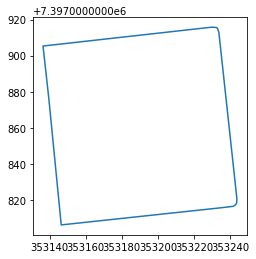

In [140]:
gdf_faces = gdf_lotes.dissolve(by=['cd_quadra_fiscal', 'cd_setor_fiscal']).boundary
gdf_faces.plot()

## Obter o centroide de cada segmento de linha

Agora é possível obter o centroide de cada segumento de linha, que é com bastante certeza um ponto dentro de um lote

In [141]:
gdf_faces = gpd.GeoDataFrame(geometry=gdf_faces).reset_index().explode()

In [142]:
def centroide_por_segmento(linha):
    segmentos = list(map(LineString, zip(linha.coords[:-1], linha.coords[1:])))
    centroides = list(map(lambda x: x.centroid, segmentos))
    return MultiPoint(centroides)

# gdf_faces.geometry.apply(lambda x: centroide_por_segmento(x))
gdf_pontos_faces = gpd.GeoDataFrame(geometry=gdf_faces.geometry.apply(lambda x: centroide_por_segmento(x)))

<AxesSubplot:>

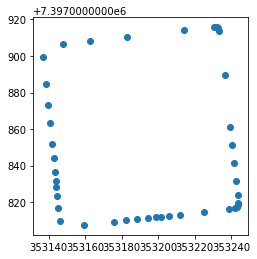

In [143]:
gdf_pontos_faces.reset_index().explode().plot()

## Relacionando os pontos aos lotes


In [144]:
gdf_lotes_buffered = gpd.GeoDataFrame(gdf_lotes, geometry=gdf_lotes.buffer(.30))

In [145]:
gdf_pontos_lotes = gpd.sjoin(gdf_pontos_faces.reset_index().explode(), gdf_lotes_buffered, how='left')

## Conectando os pontos ao eixo viário



<AxesSubplot:>

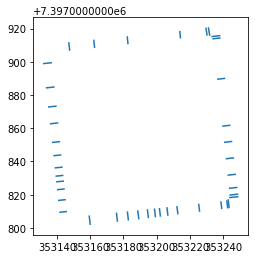

In [146]:
gdf_conexoes = gpd.GeoDataFrame(gdf_pontos_lotes, \
    geometry=gdf_pontos_lotes.geometry.apply(lambda x: \
        LineString(nearest_points(x, gdf_vias.unary_union))))
gdf_conexoes.plot()

## Relacionando as linhas aos lotes e ao viário

In [147]:
gdf_vias_buffered = gpd.GeoDataFrame(gdf_vias, geometry=gdf_vias.buffer(0.5))

In [148]:
gdf_vias.codlog.value_counts()

046906    1
062464    1
116262    1
302228    1
Name: codlog, dtype: int64

In [149]:
gdf_conexoes = gdf_conexoes.droplevel(level=1).reset_index()\
    .drop(columns=['index', 'level_0', 'level_1', 'index_right'])

In [150]:
gdf_conexoes_relacionadas = gpd.sjoin(gdf_conexoes, \
    gdf_vias_buffered, how='left', op='intersects')

In [151]:
att_out = [
    'cd_setor_fiscal',
    'cd_tipo_quadra',
    'cd_quadra_fiscal',
    'cd_subquadra_fiscal',
    'cd_lote', 
    'cd_condominio',
    'codlog',
    'geometry'
]

<AxesSubplot:>

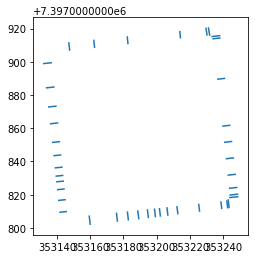

In [153]:
gdf_conexoes_relacionadas[att_out].plot()

## Relacionando faces de lote ao Logradouro

In [165]:
def segmentos(linha):
    segmentos = list(map(LineString, zip(linha.coords[:-1], linha.coords[1:])))
    # centroides = list(map(lambda x: x.centroid, segmentos))
    return MultiLineString(segmentos)

gdf_faces_segmentos = gpd.GeoDataFrame(geometry=gdf_faces.geometry.apply(lambda x: segmentos(x)))

In [177]:
gdf_faces_segmentos = gdf_faces_segmentos.droplevel(1).explode().droplevel(0)

In [189]:
gdf_conexoes_relacionadas_buffered = gpd.GeoDataFrame(gdf_conexoes_relacionadas[att_out],\
    geometry=gdf_conexoes_relacionadas[att_out].buffer(.30))

In [191]:
# gdf_conexoes_relacionadas_buffered.columns

In [192]:
gdf_testadas = gpd.sjoin(gdf_faces_segmentos, gdf_conexoes_relacionadas_buffered)

In [230]:
pd.Series(gdf_testadas[att_out].fillna('').values.tolist()).str.join('')

0     114F003007300062464
1     114F003007300116262
2     114F003007200116262
3     114F003007100116262
4     114F003008900116262
5     114F003008900116262
6     114F003006400116262
7     114F003003300116262
8     114F003003200116262
9     114F003008000116262
10    114F003006300116262
11    114F003006300116262
12    114F003000100116262
13    114F003000100046906
14    114F003001000046906
15    114F003006300046906
16    114F003006300046906
17    114F003006300046906
18    114F003006300046906
19    114F003006300302228
20    114F003006300302228
21    114F003006300302228
22    114F003006300302228
23    114F003006300302228
24    114F003008400302228
25    114F003008300302228
26    114F003008200302228
27    114F003008500302228
28    114F003008100302228
29    114F003008100302228
30    114F003008100302228
31    114F003008100302228
32    114F003008100302228
33    114F003008100062464
34    114F003008100062464
35    114F003008100062464
36    114F003008100062464
37    114F003008100062464
38    114F00

In [248]:
att_out.remove('cd_subquadra_fiscal')

In [216]:
# gdf_testadas['id_unico'] = pd.Series(gdf_testadas[att_out].fillna('').values.tolist()).str.join('')

In [240]:
# pd.Series(gdf_testadas[att_out].fillna('').values.tolist()).str.join('')
# gdf_testadas[att_out].fillna('')

In [249]:
gdf_testadas[att_out]

,cd_setor_fiscal,cd_tipo_quadra,cd_quadra_fiscal,cd_lote,cd_condominio,codlog
0,114,F,003,0073,00,062464
1,114,F,003,0073,00,116262
2,114,F,003,0072,00,116262
3,114,F,003,0071,00,116262
4,114,F,003,0089,00,116262
5,114,F,003,0089,00,116262
6,114,F,003,0064,00,116262
7,114,F,003,0033,00,116262
8,114,F,003,0032,00,116262
9,114,F,003,0080,00,116262


In [250]:
gdf_testadas.dissolve(by=att_out, as_index=False)

,cd_setor_fiscal,cd_tipo_quadra,cd_quadra_fiscal,cd_lote,cd_condominio,codlog,geometry,index_right,cd_subquadra_fiscal,id_unico
0,114,F,003,0001,00,046906,"LINESTRING (353136.290 7397905.329, 353158.939...",13,None,114F003000100046906
1,114,F,003,0001,00,116262,"LINESTRING (353137.584 7397893.619, 353136.290...",12,None,114F003000100116262
2,114,F,003,0010,00,046906,"LINESTRING (353158.939 7397907.859, 353166.345...",14,None,114F003001000046906
3,114,F,003,0032,00,116262,"LINESTRING (353142.267 7397848.099, 353141.505...",8,None,114F003003200116262
4,114,F,003,0033,00,116262,"LINESTRING (353143.077 7397839.835, 353142.267...",7,None,114F003003300116262
5,114,F,003,0063,00,046906,"MULTILINESTRING ((353166.345 7397908.686, 3531...",15,None,114F003006300046906
6,114,F,003,0063,00,116262,"MULTILINESTRING ((353140.060 7397870.603, 3531...",10,None,114F003006300116262
7,114,F,003,0063,00,302228,"MULTILINESTRING ((353231.214 7397915.722, 3532...",19,None,114F003006300046906
8,114,F,003,0064,00,116262,"LINESTRING (353143.707 7397833.412, 353143.077...",6,None,114F003006400116262
9,114,F,003,0066,00,062464,"LINESTRING (353185.507 7397810.314, 353179.165...",39,None,114F003008100062464


## Resultado

In [251]:
gdf_testadas.dissolve(by=att_out, as_index=False).to_file('resultados/poc2-testadas.gpkg', driver='GPKG')